In [1358]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller

Read Gold (D1) data:

In [1359]:
dfG=pd.read_csv('quotes/AU(D).csv') 
dfG.columns=['date','time','open','high','low','close','volume'] 
dfG=dfG[['date','open','close','low','high']]
dfG.set_index('date',inplace=True)
dfG=dfG.drop(['high','low','open'], axis=1) 
dfG.rename(columns={'close':'closeG'},inplace=True)
dfG.index=pd.to_datetime(dfG.index)
dfG.head(0)

,closeG
date,


Read Silver (D1) data:

In [1360]:
dfS=pd.read_csv('quotes/AG(D).csv') 
dfS.columns=['date','time','open','high','low','close','volume'] 
dfS=dfS[['date','open','close','low','high']]
dfS.set_index('date',inplace=True)
dfS=dfS.drop(['high','low','open'], axis=1) 
dfS.rename(columns={'open':'openS','close':'closeS'},inplace=True)
dfS.index=pd.to_datetime(dfS.index)
dfS.head(0)

,closeS
date,


Merging of 2 frames by indexes:

In [1361]:
df=pd.merge(dfS,dfG,how='inner',left_index=True,right_index=True)
df=df.dropna()
df.head()

,closeS,closeG
date,,
2011-09-28,29.893,1608.23
2011-09-29,30.592,1614.27
2011-09-30,29.671,1623.23
2011-10-03,30.390,1660.63
2011-10-04,30.183,1624.38


Convert prices to returns by log function and taking differences:

In [1362]:
df=df[['closeS','closeG']].apply(np.log)
df=df.diff(axis=0,periods=1)
df=df.dropna()
df.head()

,closeS,closeG
date,,
2011-09-29,0.023114,0.003749
2011-09-30,-0.030568,0.005535
2011-10-03,0.023943,0.022779
2011-10-04,-0.006835,-0.022071
2011-10-05,0.009332,0.010356


Normalize returns to avoid model instability:

In [1363]:
df=(df-df.min())/(df.max()-df.min())
df=df.dropna()
df.head()

,closeS,closeG
date,,
2011-09-29,0.777206,0.693015
2011-09-30,0.525478,0.705465
2011-10-03,0.781094,0.825640
2011-10-04,0.636770,0.513077
2011-10-05,0.712581,0.739065


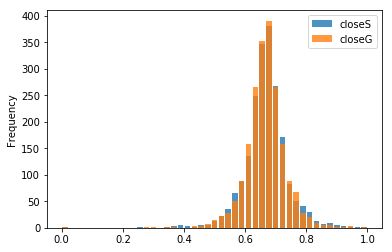

In [1364]:
df[['closeS','closeG']].plot.hist(bins=int(np.sqrt(len(df))),rwidth=0.8,alpha=0.8)
plt.show()

In [1365]:
df.describe()

,closeS,closeG
count,2045.000000,2045.000000
mean,0.667683,0.666740
std,0.070409,0.064918
min,0.000000,0.000000
25%,0.633530,0.633333
50%,0.669060,0.668058
75%,0.701522,0.699748
max,1.000000,1.000000


Look at the outliers:

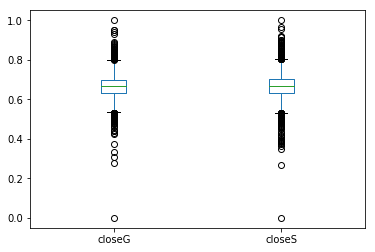

In [1366]:
df[['closeG','closeS']].boxplot(grid=False) 
plt.show()

We may remove outliers - we ignore them in future pipeline:

In [1367]:
df=df[df[['closeG','closeS']]>0.2]
df=df.dropna()

Create scatter plot of Gold vs Silver:

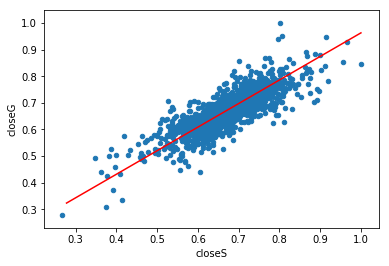

                            OLS Regression Results                            
Dep. Variable:                 closeG   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     3988.
Date:                Wed, 28 Aug 2019   Prob (F-statistic):               0.00
Time:                        14:11:14   Log-Likelihood:                 3850.1
No. Observations:                2044   AIC:                            -7696.
Df Residuals:                    2042   BIC:                            -7685.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1682      0.008     21.177      0.0

In [1368]:
df.plot.scatter(x='closeS',y='closeG')
plt.plot(np.unique(df['closeG']),np.poly1d(np.polyfit(df['closeG'], df['closeS'], 1))(np.unique(df['closeG'])),color='r')
plt.show()

results=sm.OLS(df['closeG'],sm.add_constant(df['closeS'])).fit()
print(results.summary())

Look at the relative return:

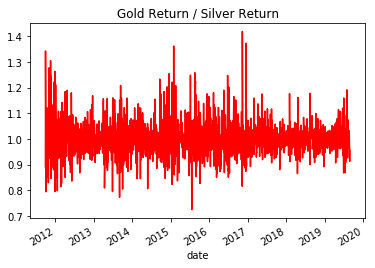

In [1369]:
df['Relative return']=df['closeG']/df['closeS']
df['Relative return'].plot(color='r')
plt.title('Gold Return / Silver Return')
plt.show()

In [1370]:
df['Relative return'].describe()

count    2044.000000
mean        1.001477
std         0.063715
min         0.725368
25%         0.966051
50%         0.999828
75%         1.032229
max         1.418389
Name: Relative return, dtype: float64

Median (50%) is close to the average value. The distribution is quite close to ND.

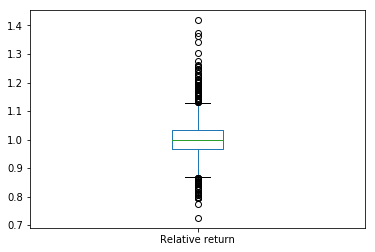

In [1371]:
dfR=df['Relative return']
dfR.plot.box(grid=False) 
plt.show()

Relative return seems to be mean reverting to the parity. Let's check linear regression with cross validation:

In [1372]:
df['closeS1']=df['closeS'] 
df.rename(columns={'closeS':'closeS0'},inplace = True)
df=df[['closeS0','closeS1','closeG','Relative return']]

array=df.values

X=array[:,0:2]
Y=array[:,2]

kfold=KFold(n_splits=10,random_state=7)
model=LinearRegression()
model.fit(X,Y)

results=cross_val_score(model,X,Y,cv=kfold,scoring='r2')
print('Average R2:',int(100*round(results.mean(),2)),'%')
print('Scattering of R2:',int(100*round(results.std(),2)),'%')

Average R2: 65 %
Scattering of R2: 7 %


Score is quite stable to resampling. 
Now we check the relative return for stationarity by ADF test: 

In [1373]:
z=df['Relative return'].values
result=adfuller(z)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -47.692177
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


We can reject the HO of time series stationarity.

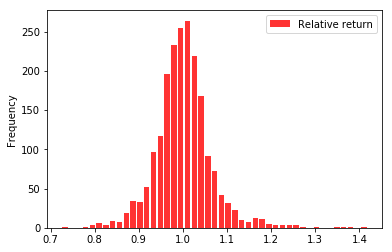

In [1374]:
df[['Relative return']].plot.hist(bins=int(np.sqrt(len(df))),rwidth=0.8,alpha=0.8,color='r')
plt.show()